In [3]:
from model import A3C_LSTM
from env import SimpleBandit, generate_bandit

import numpy as np
import torch as T
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from time import time
from tqdm.notebook import tqdm

In [4]:
# test env
env_bandit = generate_bandit(independent=True)
print(env_bandit.action(0))  

tensor([0.])


# Training

In [5]:
device = 'cpu'
# training env param
num_episode = 10000 #20000
count_trial = 1
num_update = 100
num_trial = count_trial * num_update


# hyper-param
learning_rate = 5e-4
gamma = .8
gae_lambda = 1.
entropy_coeff = 1e-3
value_coeff = 5e-2

In [6]:
# load model and optimizer
agent = A3C_LSTM(48, 2)
agent.to(device)
agent.train()
optimizer = T.optim.RMSprop(agent.parameters(), lr=learning_rate)
# intialize a, r, memory

p_action = [0, 0]
p_reward = 0
p_mem = agent.get_init_states()

In [8]:
for i in tqdm(range(num_episode)):
    new_bandit = generate_bandit()
    for j in range(count_trial):
        values = []
        log_probs = []
        rewards = []
        entropies = []
        # detach memory before each sampling
        p_mem = p_mem[0].detach(), p_mem[0].detach()
        for k in range(num_update):
            timestep = T.tensor([[k]]).float().to(device)
            logit, value, p_mem = agent(timestep,
                (T.tensor([p_action]).float().to(device), 
                 T.tensor([[p_reward]]).float().to(device)),
                p_mem)
            
            logit = logit.squeeze(0)
            prob = F.softmax(logit, dim=-1)
            log_prob = F.log_softmax(logit, dim=-1)
            entropy = -(log_prob * prob).sum(1, keepdim=True)
            action = prob.multinomial(num_samples=1).detach()
            
            log_prob = log_prob.gather(1, action)
            
            reward = new_bandit.action(int(action))[0]
            
            p_action = np.eye(2)[int(action)]
            p_reward = reward
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            entropies.append(entropy)
            
    # calculate policy & value loss, back propogate
        R = T.zeros(1, 1).to(device)
        _, value, _ =  agent(timestep,
                    (T.tensor([p_action]).float().to(device), 
                     T.tensor([[p_reward]]).float().to(device)),
                    p_mem)
        R = value.detach()
        values.append(R)
        policy_loss = 0
        value_loss = 0
        gae = T.zeros(1, 1).to(device)

        for i in reversed(range(len(rewards))):
            R = gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss += .5 * advantage.pow(2)

            delta_t = rewards[i] + gamma * values[i + 1] - values[i]
            gae = gae * gamma * gae_lambda + delta_t
            policy_loss -= log_probs[i] * gae.detach() - entropy_coeff * entropies[i]

        loss = policy_loss + value_coeff * value_loss 
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    

In [9]:
#T.save(agent.state_dict(), './trained/agent_dependent')

# Testing

In [41]:
agent = A3C_LSTM(48, 2)
agent.to(device)
agent.load_state_dict(T.load('./trained/agent_dependent'))
agent.eval()

p_test = .6
test_bandit = SimpleBandit(T.tensor([p_test]))

p_action = [0, 0]
p_reward = 0
p_mem = agent.get_init_states()

In [42]:
regrets = np.zeros(100)
rewards = np.zeros(100)
actions = []
num_episode_test = 100
for i in range(num_episode_test):
    regret = 0
    reward = 0
    p_action = [0, 0]
    p_reward = 0
    p_mem = agent.get_init_states()
    for k in range(num_trial):
        timestep = T.tensor([[k]]).float().to(device)
        logit, value, p_mem = agent(timestep,
                    (T.tensor([p_action]).float().to(device), 
                     T.tensor([[p_reward]]).float().to(device)),
                    p_mem)

        logit = logit.squeeze(0)
        prob = F.softmax(logit, dim=-1)
        log_prob = F.log_softmax(logit, dim=-1)
        entropy = -(log_prob * prob).sum(1, keepdim=True)
        action = prob.multinomial(num_samples=1).detach()
        reward = test_bandit.action(int(action))
        regret += 2 * p_test - 1 if int(action) != 1 else 0
        regrets[k] += regret
        if i == 0:
            actions.append(int(action))
regrets /= num_episode_test

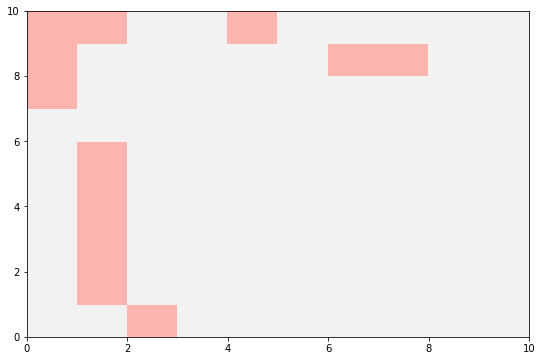

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
actions = np.array(actions).reshape(10,10).T
cm=plt.cm.get_cmap('Pastel1')
plt.pcolormesh(actions, cmap=cm)

# Implement UCB

In [44]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
class ucb_bandit:
    def __init__(self, k, c, iters, p):
        # Number of arms
        self.k = k
        # Exploration parameter
        self.c = c
        self.iters = iters
        self.n = 1
        self.k_n = np.ones(k)
        self.cul_regret = 0
        self.regret = np.zeros(iters)
        self.k_reward = np.zeros(k)
        
        self.mu = [p, 1-p]
        
    def pull(self):
        a = np.argmax(self.k_reward + self.c * np.sqrt(
                (np.log(self.n)) / self.k_n))
            
        reward = np.random.binomial(1, self.mu[a])
        if a == 1:
            self.cul_regret += 2*p_test - 1
        self.n += 1
        self.k_n[a] += 1
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.regret[i] = self.cul_regret
            
    def reset(self, mu=None):
        self.n = 1
        self.k_n = np.ones(self.k)
        self.cul_regret = 0
        self.regret = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
            
k = 2 
iters = 100
ucb_regrets = np.zeros(iters)
ucb = ucb_bandit(k, 1, iters, p_test)
episodes = 100
for i in range(episodes): 
    ucb.reset()
    ucb.run()
    
    ucb_regrets = ucb_regrets + (
        ucb.regret - ucb_regrets) / (i + 1)
    


# Implement Thompson Sampling

In [37]:
class ThompsonSocket():
    def __init__( self ):             
                
        self.alpha = 1  # the number of times this socket returned a charge        
        self.beta = 1  # the number of times no charge was returned    
                    
    def update(self,R):
        """ increase the number of times this socket has been used and 
            update the counts of the number of times the socket has and 
            has not returned a charge (alpha and beta)"""
        self.alpha += R
        self.beta += (1-R)
        
    def sample(self):
        """ return a value sampled from the beta distribution """
        return np.random.beta(self.alpha, self.beta)


episode_test = 100
iter_test = 100
thompson_regrets = np.zeros(iter_test)
for i in range(episode_test):
    sockets = [ThompsonSocket(), ThompsonSocket()]
    thompson_regret = 0
    for j in range(iter_test):
        samples = [s.sample() for s in sockets]
        action = np.argmax(samples)
        thompson_regret += 2 * p_test - 1 if action == 1 else 0
        reward =test_bandit.action(action)
        sockets[action].update(reward)
        thompson_regrets[j] += thompson_regret
thompson_regrets /= episode_test


In [45]:
dependent_regrets = regrets

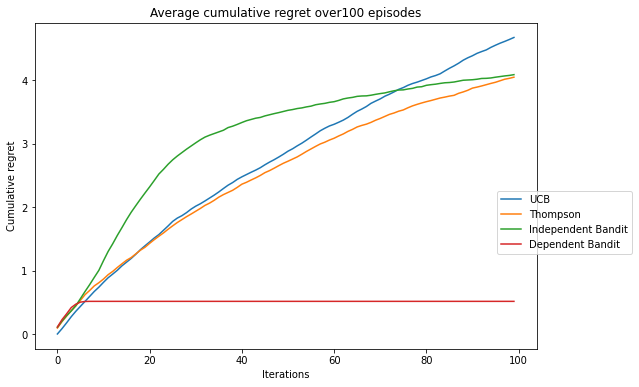

In [51]:
plt.figure(figsize=(9,6))
plt.plot(ucb_regrets, label="UCB")
plt.plot(thompson_regrets, label="Thompson")
plt.plot(independent_regrets, label='Independent Bandit')
plt.plot(dependent_regrets, label='Dependent Bandit')
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Cumulative regret")
plt.title("Average cumulative regret over" 
          + str(episodes) + " episodes")
plt.show()